In [1]:
import torch
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import os
import cv2

In [2]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

In [3]:
train_set_path = r"C:\Users\Kaushik\Desktop\anacondaDocs\flower classifier kaggle\flowers-recognition\flowers"
print("training set located at: ",train_set_path)

training set located at:  C:\Users\Kaushik\Desktop\anacondaDocs\flower classifier kaggle\flowers-recognition\flowers


In [4]:
# checking for cuda
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("using: ",device)
torch.cuda.get_device_name(0)
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
    

using:  cuda
GeForce MX130
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
data_transforms = {'train': transforms.Compose([transforms.Resize(size=(224,244)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

In [6]:
train_data = Datasets.ImageFolder(train_set_path, transform = data_transforms['train'])
type(train_data)

torchvision.datasets.folder.ImageFolder

In [7]:
print("number of images to train:",len(train_data))

number of images to train: 4323


In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 40
# percentage of training set to use as validation
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler = train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

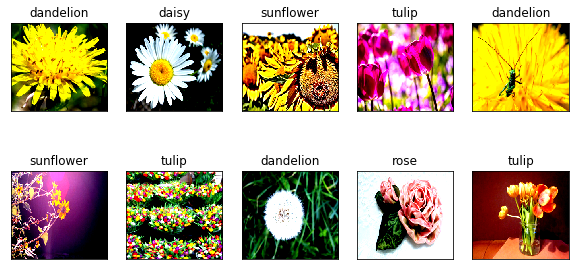

In [9]:
classes = ["daisy","dandelion","rose","sunflower","tulip"]
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10,5))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [10]:
# Load the pretrained model from pytorch
classifier = models.resnet18(pretrained=True)
# print out the model structure
print(classifier)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
for param in classifier.parameters():
    param.requires_grad = False

In [12]:
classifier.fc

Linear(in_features=512, out_features=1000, bias=True)

In [13]:
print(len(classes))

5


In [14]:
classifier.fc = nn.Linear(512, len(classes))

In [15]:
print("modified classifier:",classifier)

modified classifier: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): 

In [16]:
if device == "cuda":
    classifier.cuda()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.fc.parameters(), lr=0.001)

In [18]:
def train(n_epochs, train_loader,valid_loader, model, optimizer, criterion, device, save_path):
    valid_loss_min = np.Inf
    for epoch in (range(1,n_epochs+1)):
        train_loss = 0
        valid_loss = 0
        model.train()
        for batch_idx, (data,target) in enumerate(train_loader):
            if device=="cuda":
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            print('training batch {}, loss {:.6f}'.format(batch_idx, train_loss), end='\r')
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if device=="cuda":
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            print('validation batch {}, loss {:.6f}'.format(batch_idx, valid_loss), end='\r')
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [19]:
classifier = train(n_epochs = 10, train_loader=train_loader, valid_loader=valid_loader, model=classifier, optimizer=optimizer, criterion=criterion, device=device, save_path="trained_model.pt")

Epoch: 1 	Training Loss: 1.457335 	Validation Loss: 1.287791
Validation loss decreased (inf --> 1.287791).  Saving model ...
Epoch: 2 	Training Loss: 1.191437 	Validation Loss: 1.089746
Validation loss decreased (1.287791 --> 1.089746).  Saving model ...
Epoch: 3 	Training Loss: 1.029474 	Validation Loss: 0.954224
Validation loss decreased (1.089746 --> 0.954224).  Saving model ...
Epoch: 4 	Training Loss: 0.914542 	Validation Loss: 0.862483
Validation loss decreased (0.954224 --> 0.862483).  Saving model ...
Epoch: 5 	Training Loss: 0.835311 	Validation Loss: 0.789758
Validation loss decreased (0.862483 --> 0.789758).  Saving model ...
Epoch: 6 	Training Loss: 0.773289 	Validation Loss: 0.737962
Validation loss decreased (0.789758 --> 0.737962).  Saving model ...
Epoch: 7 	Training Loss: 0.721597 	Validation Loss: 0.699485
Validation loss decreased (0.737962 --> 0.699485).  Saving model ...
Epoch: 8 	Training Loss: 0.682839 	Validation Loss: 0.668224
Validation loss decreased (0.69948

In [19]:
test_set_path = r"C:\Users\Kaushik\Desktop\anacondaDocs\flower classifier kaggle\flowers-recognition\flowers-test"
print("test set located at: ",test_set_path)

test_set = Datasets.ImageFolder(test_set_path, transform = data_transforms["test"])
print("size of test_set",len(test_set))

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

test set located at:  C:\Users\Kaushik\Desktop\anacondaDocs\flower classifier kaggle\flowers-recognition\flowers-test
size of test_set 4323


In [20]:
def test(loaders, model, criterion, device):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if device == "cuda":
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
        print('test batch {}, loss {:.6f}'.format(batch_idx, test_loss), end='\r')
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [21]:
classifier.load_state_dict(torch.load("trained_model.pt"))

<All keys matched successfully>

In [22]:
test(loaders=test_loader, criterion=criterion, device=device, model=classifier)

Test Loss: 0.565594s 0.565594


Test Accuracy: 84% (3647/4323)


In [45]:
from PIL import Image

def get_img(img_path):
    image = Image.open(img_path)
    image.show()
    transform = data_transforms["test"]
    image = transform(image)
    return image

In [93]:
img = get_img(r"C:\Users\Kaushik\Desktop\sunflower.jfif")

In [94]:
def get_prediction(image, model):
    prediction = None
    image = image.unsqueeze(0)
    image = image.cuda()
    predicted_values = model(image)
    if prediction is None:
        prediction = predicted_values.data.cpu()
    else:
        prediction = torch.cat((prediction, prediction.data.cpu()), dim=0)
    _, preds = torch.max(prediction, 1)
    preds = preds.numpy()
    print(classes[preds[0]])

In [95]:
get_prediction(image=img, model=classifier)

sunflower
